In [38]:
from reader import parse_data, list_to_freq_dict, parse_data_test
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import os
import json
import numpy as np
import multiprocessing
import time
from sklearn import metrics
import seaborn as sn

pp = pprint.PrettyPrinter(indent=4)

In [2]:
def load_dataset(path, training=True):

    if training == True:
        word_list = []
        tag_list = []
        word_tags_list = []
        
        for subdir, dirs, files in os.walk(path):
            for file in files:

                fileName = subdir + '/' + str(file)
                words, tags, word_tags = parse_data(fileName)

                word_list.extend(words)
                tag_list.extend(tags)
                word_tags_list.extend(word_tags)
            
        return word_list, tag_list, word_tags_list
        
    else:
        all_tuples = []
        
        for subdir, dirs, files in os.walk(path):
            for file in files:

                fileName = subdir + '/' + str(file)
                tuples = parse_data_test(fileName)
                all_tuples.extend(tuples)

        return all_tuples

In [3]:
# Load Dataset

train_path = 'Train-corpus/'
test_path = 'Test-corpus/'

# word_list, tag_list, word_tags_list = load_dataset(train_path)
test_tuples = load_dataset(test_path, training=False)

In [ ]:
# Generate Frequency Dict for words

word_dict = list_to_freq_dict(word_list)

with open('words.json', 'w') as outfile:
    json.dump(word_dict, outfile, indent=4)

In [ ]:
# Print top 10 words

k1 = Counter(word_dict)
top_words = k1.most_common(10)
print('Top 10 Words are: ')
for i in top_words:
    print(i[0], " :", i[1], " ")

In [ ]:
# Plot Top 10 Words

keys, values = [i[0] for i in top_words], [i[1] for i in top_words]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keys,values)
plt.show()

patches, texts = plt.pie(values, labels=keys)
plt.legend(patches, keys, loc="best")
plt.savefig('words_chart.png')
plt.show()

In [ ]:
# Generate Frequency Dict for tags

tag_dict = list_to_freq_dict(tag_list)
with open('tags.json', 'w') as outfile:
    json.dump(tag_dict, outfile, indent=4)

In [ ]:
# Print Top 10 Tags

k1 = Counter(tag_dict)
top_tags = k1.most_common(10)
print('Top 10 Tags are: ')
for i in top_tags:
    print(i[0], " :", i[1], " ")

In [ ]:
# Plot Top 10 Tags

keys, values = [i[0] for i in top_tags], [i[1] for i in top_tags]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keys,values)
plt.show()

patches, texts = plt.pie(values, labels=keys)
plt.legend(patches, keys, loc="best")
plt.savefig('tags_chart.png')
plt.show()

In [ ]:
# Generate Frequency Dict for word_tags

word_tags_dict = list_to_freq_dict(word_tags_list)
with open('word_tags.json', 'w') as outfile:
    json.dump(word_tags_dict, outfile, indent=4)

In [4]:
# Load JSON Files

with open('words.json') as f:
    word_dict = json.load(f)
with open('tags.json') as f:
    tag_dict = json.load(f)
with open('word_tags.json') as f:
    word_tags_dict = json.load(f)

In [5]:
print(len(tag_dict))
print(len(word_dict))
print(len(word_tags_dict))

57
192634
252564


In [6]:
# Use Laplace Smoothing
def probability_word_given_tag(word, tag):
    
    count_tag = tag_dict[tag]
    
    if word+'_'+tag in word_tags_dict.keys():
        count_word_tag = word_tags_dict[word+'_'+tag]

        return (count_word_tag)/(count_tag)
    
    else:
        return 1/(count_tag + 1)

In [7]:
print(probability_word_given_tag('a','AT0'))

0.23395366546859694


In [8]:
def best_tag_for_word(word):
    max_prob = 0
    most_prob_tag = 'none'
    for tag in tag_dict.keys():
        p_word_tag = probability_word_given_tag(word,tag)
        p_tag = tag_dict[tag]
        
        p_tag_word = (p_word_tag*p_tag)
        
        if max_prob < p_tag_word:
            max_prob = p_tag_word
            most_prob_tag = tag
    
    return most_prob_tag

In [9]:
def create_model():
    model = {}
    for word in word_dict.keys():
        model[word] = best_tag_for_word(word)
    return model

In [10]:
model = create_model()

In [11]:
print(model['of'])

PRF


In [12]:
print(len(test_tuples))

3630025


In [13]:
def check_prediction(word_tuple):
    
    word, label = word_tuple
    logit = best_tag_for_word(word)
    if logit in label:
        return True
    else:
        return False

In [14]:
def get_model_accuracy(test_tuples):
    
    correct = 0
    incorrect = 0
    
    err = 0
    
    print("Total: %d" % len(test_tuples))
    
    t0 = time.process_time()
    
    for i in range(0,len(test_tuples)):
        
        word, label = test_tuples[i]
        
        if word in model.keys():
            if model[word] in label:
                correct = correct + 1
            else:
                incorrect = incorrect + 1
        
        else:
            err = err + 1
            if best_tag_for_word(word) in label:
                correct = correct + 1
            else:
                incorrect = incorrect + 1
                
        
    print("Evaluated: %d " % (incorrect + correct))    
    print("Time Taken: %.2f \n " % (time.process_time()-t0))
    
    print("Final Accuracy = %.06f"  % (correct/(correct+incorrect)))
    print("Errors: %d " % err)

In [15]:
get_model_accuracy(test_tuples)

Total: 3630025
Evaluated: 3630025 
Time Taken: 2.90 
 
Final Accuracy = 0.912357
Errors: 65350 


In [36]:
tags = list(tag_dict.keys())
def get_confusion_matrix(test_tuples):
    y_true = []
    y_pred = []
    for i in range(0,len(test_tuples)):
        word, label = test_tuples[i]
        y_true.append(label)
        if word in model.keys():
            y_pred.append(model[word])
        else:
            y_pred.append(best_tag_for_word(word))
    plt.figure(figsize=(25, 22), dpi=10)
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred, tags), tag_dict.keys(), tag_dict.keys())
    sn.set(font_scale=1.0)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 5}) # font size
    # plt.show()
    # plt.savefig('confusion_matrix.png')
    plt.savefig('cm.svg', format='svg', dpi=10)
    # print(metrics.confusion_matrix(y_true, y_pred))

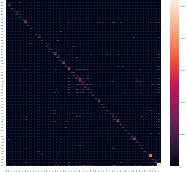

In [37]:
get_confusion_matrix(test_tuples)